# Import files

In [43]:
from Strats.MeanReversionStrat import *
from Strats.RegressionStrat import *
from Strats.SimpleStrat import *
from Strats.TrendStrat import *

from PnL_Metrics.PortfolioMetrics import *
from PnL_Metrics.WRC import *
from PnL_Metrics.Backtest import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

## Mean-Reversion

In [92]:
# test_pairs = coint_pairs[:4]
test_cons = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
print(test_cons)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_cons:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
portfolio_prices = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2024-07-01",
        end_date="2025-05-31"
    )

portfolio_prices

['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
'BTCUSDT' added successfully.
'ETHUSDT' added successfully.
'BNBUSDT' added successfully.


,timestamp,BNBUSDT,BTCUSDT,ETHUSDT
0,2024-07-01 00:00:00,582.00,62722.08,3437.02
1,2024-07-01 00:05:00,580.60,62648.49,3433.81
2,2024-07-01 00:10:00,580.40,62624.00,3435.74
3,2024-07-01 00:15:00,581.00,62682.02,3438.27
4,2024-07-01 00:20:00,581.30,62674.01,3438.29
...,...,...,...,...
96188,2025-05-30 23:40:00,655.13,103802.36,2518.88
96189,2025-05-30 23:45:00,656.09,104067.40,2527.38
96190,2025-05-30 23:50:00,655.80,104010.45,2528.39
96191,2025-05-30 23:55:00,655.36,103985.48,2531.34


In [3]:
model = MeanReversionStrat(portfolio_prices.copy(), test_cons)
spread = model.generate_signals(lookback=8640, execute_threshold=1.5, close_threshold=1)
spread

100%|██████████| 87553/87553 [00:07<00:00, 11831.91it/s]


,timestamp,BNBUSDT,BTCUSDT,ETHUSDT,BTCUSDT_rolling_mean,BTCUSDT_rolling_std,BTCUSDT_z_scores,BTCUSDT_is_mean_revert,BTCUSDT_signal,BTCUSDT_exit_signal,...,ETHUSDT_z_scores,ETHUSDT_is_mean_revert,ETHUSDT_signal,ETHUSDT_exit_signal,BNBUSDT_rolling_mean,BNBUSDT_rolling_std,BNBUSDT_z_scores,BNBUSDT_is_mean_revert,BNBUSDT_signal,BNBUSDT_exit_signal
0,2024-07-01 00:00:00,582.00,62722.08,3437.02,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
1,2024-07-01 00:05:00,580.60,62648.49,3433.81,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
2,2024-07-01 00:10:00,580.40,62624.00,3435.74,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
3,2024-07-01 00:15:00,581.00,62682.02,3438.27,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
4,2024-07-01 00:20:00,581.30,62674.01,3438.29,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96188,2025-05-30 23:40:00,655.13,103802.36,2518.88,103324.454249,4913.583066,0.097262,0,0,1,...,0.503339,0,0,1,645.190730,30.345220,0.327540,0,0,1
96189,2025-05-30 23:45:00,656.09,104067.40,2527.38,103325.592630,4912.615493,0.151000,0,0,1,...,0.529514,0,0,1,645.197262,30.341492,0.359005,0,0,1
96190,2025-05-30 23:50:00,655.80,104010.45,2528.39,103326.726086,4911.643422,0.139205,0,0,1,...,0.532468,0,0,1,645.203773,30.337729,0.349276,0,0,1
96191,2025-05-30 23:55:00,655.36,103985.48,2531.34,103327.861905,4910.660730,0.133916,0,0,1,...,0.541439,0,0,1,645.210194,30.334006,0.334602,0,0,1


In [4]:
test_start_date, test_end_date = "2024-10-01", "2025-05-31"
stoploss = 10e6
drawdown_duration = 10e6
rolling=2000
weight_method=hierarchical_risk_parity_weighting
short = False

In [5]:
mr_backtest = Backtest(spread.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
mr_pnl_df = mr_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
mr_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.0,0.000000e+00
1,2024-10-01 00:05:00,0.0,0.000000e+00
2,2024-10-01 00:10:00,0.0,0.000000e+00
3,2024-10-01 00:15:00,0.0,0.000000e+00
4,2024-10-01 00:20:00,0.0,0.000000e+00
...,...,...,...
69692,2025-05-30 23:40:00,0.0,4.917702e+06
69693,2025-05-30 23:45:00,0.0,4.917702e+06
69694,2025-05-30 23:50:00,0.0,4.917702e+06
69695,2025-05-30 23:55:00,0.0,4.917702e+06


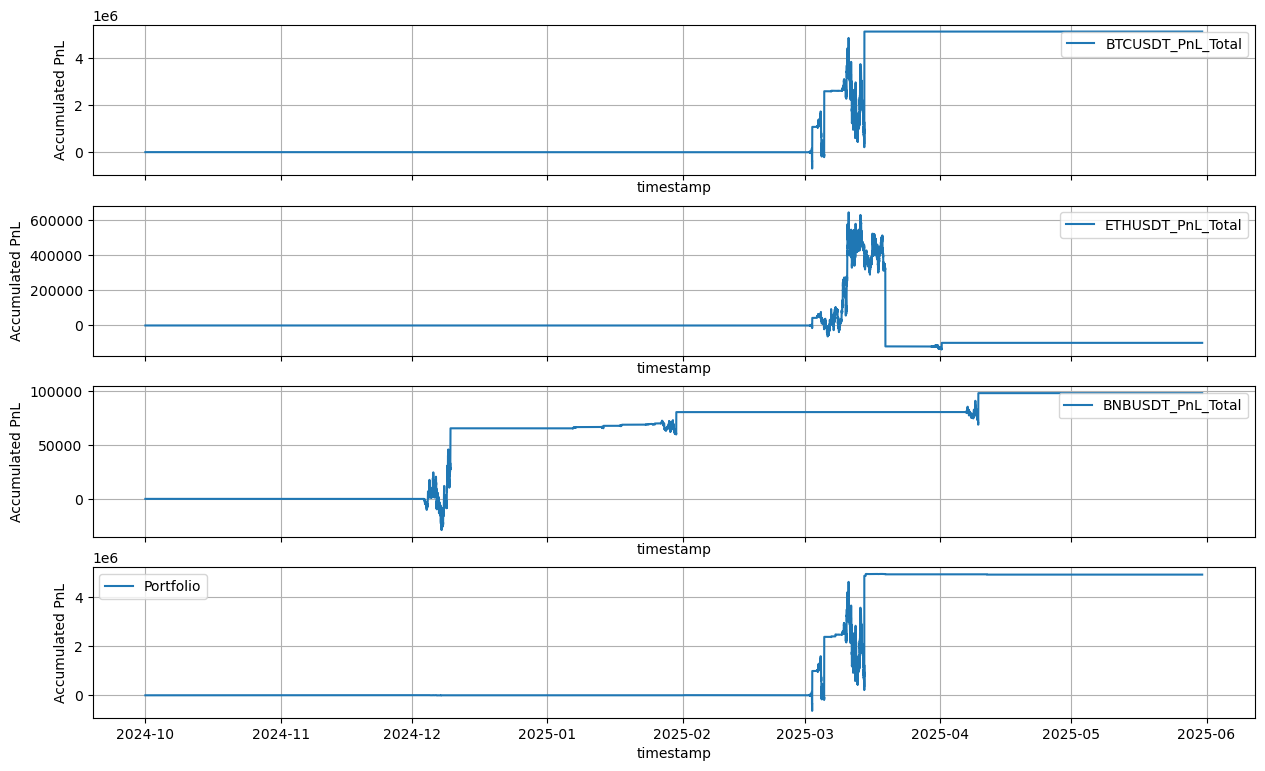

In [6]:
mr_backtest.plot_pnl(mr_pnl_df)

## Simple Momentum

In [7]:
simple_strat = SimpleStrat(data=portfolio_prices)
simple_df = simple_strat.simple_strategy(lookback=12*24*3, hold_period=12*24*3)

In [8]:
simple_backtest = Backtest(simple_df.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
simple_pnl_df = simple_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
simple_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.000000,0.000000
1,2024-10-01 00:05:00,0.000000,0.000000
2,2024-10-01 00:10:00,0.000000,0.000000
3,2024-10-01 00:15:00,0.000000,0.000000
4,2024-10-01 00:20:00,0.000000,0.000000
...,...,...,...
69692,2025-05-30 23:40:00,32.929295,17226.678178
69693,2025-05-30 23:45:00,30.489450,17224.238333
69694,2025-05-30 23:50:00,30.199539,17223.948422
69695,2025-05-30 23:55:00,29.352770,17223.101652


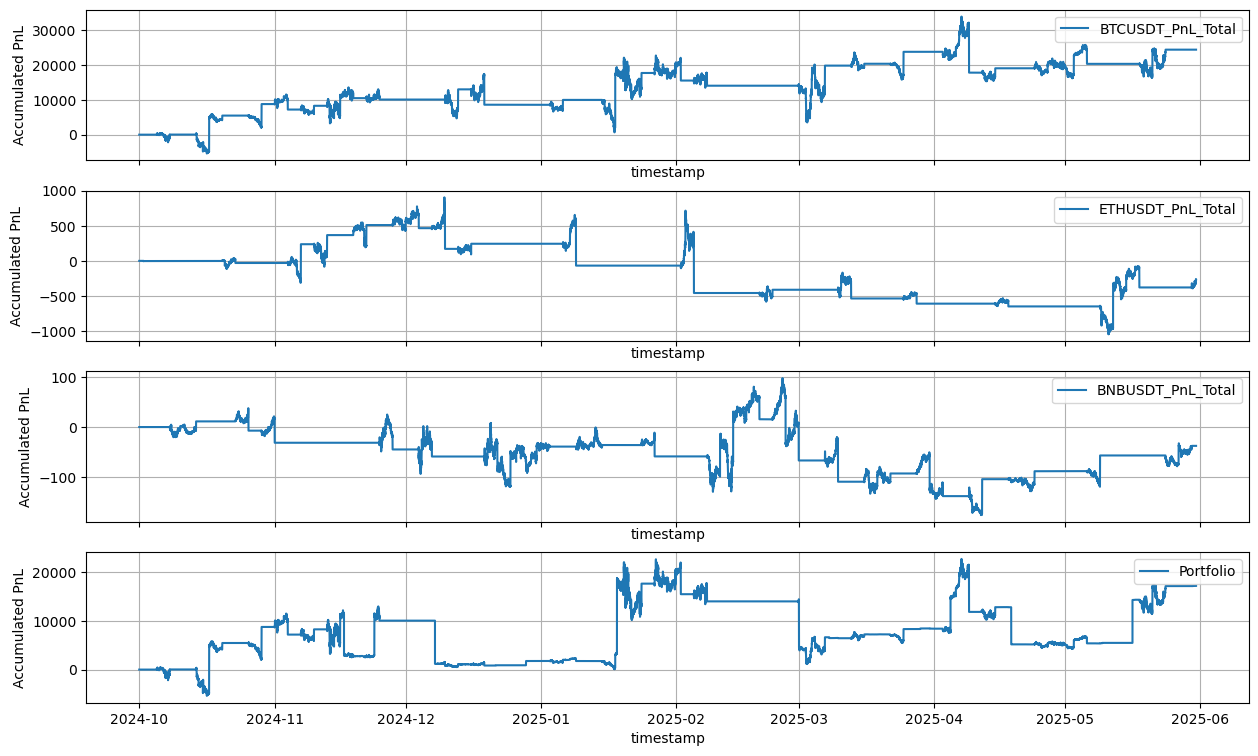

In [9]:
simple_backtest.plot_pnl(simple_pnl_df)

## Regression


In [10]:
lr_model = RegressionStrat(portfolio_prices.copy(), test_cons, lookback_window=8000, regression_type='theilsen')
lr_signals = lr_model.generate_signals(pca_components=3, threshold=0, r2_exit=RegressionStrat_PARAMS.r2_exit)
lr_signals

100%|██████████| 11/11 [00:24<00:00,  2.24s/it]


,timestamp,BNBUSDT,BTCUSDT,ETHUSDT,BTCUSDT_pred,BTCUSDT_is_trend,BTCUSDT_signal,BTCUSDT_exit_signal,ETHUSDT_pred,ETHUSDT_is_trend,ETHUSDT_signal,ETHUSDT_exit_signal,BNBUSDT_pred,BNBUSDT_is_trend,BNBUSDT_signal,BNBUSDT_exit_signal
0,2024-07-01 00:00:00,582.00,62722.08,3437.02,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
1,2024-07-01 00:05:00,580.60,62648.49,3433.81,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
2,2024-07-01 00:10:00,580.40,62624.00,3435.74,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
3,2024-07-01 00:15:00,581.00,62682.02,3438.27,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
4,2024-07-01 00:20:00,581.30,62674.01,3438.29,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96188,2025-05-30 23:40:00,655.13,103802.36,2518.88,-0.000209,1,-1,1,0.000357,1,1,1,0.000085,1,1,1
96189,2025-05-30 23:45:00,656.09,104067.40,2527.38,-0.000185,1,-1,1,0.000108,1,1,1,0.000129,1,1,1
96190,2025-05-30 23:50:00,655.80,104010.45,2528.39,-0.000317,1,-1,1,-0.000073,1,-1,1,0.000053,1,1,1
96191,2025-05-30 23:55:00,655.36,103985.48,2531.34,-0.000234,1,-1,1,0.000147,1,1,1,0.000166,1,1,1


In [11]:
lr_backtest = Backtest(lr_signals.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
lr_pnl_df = lr_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
lr_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.000000,0.000000
1,2024-10-01 00:05:00,3.892535,3.892535
2,2024-10-01 00:10:00,0.000000,3.892535
3,2024-10-01 00:15:00,-106.329169,-102.436634
4,2024-10-01 00:20:00,0.000000,-102.436634
...,...,...,...
69692,2025-05-30 23:40:00,0.000000,23064.574107
69693,2025-05-30 23:45:00,-265.022763,22799.551344
69694,2025-05-30 23:50:00,0.000000,22799.551344
69695,2025-05-30 23:55:00,24.968244,22824.519588


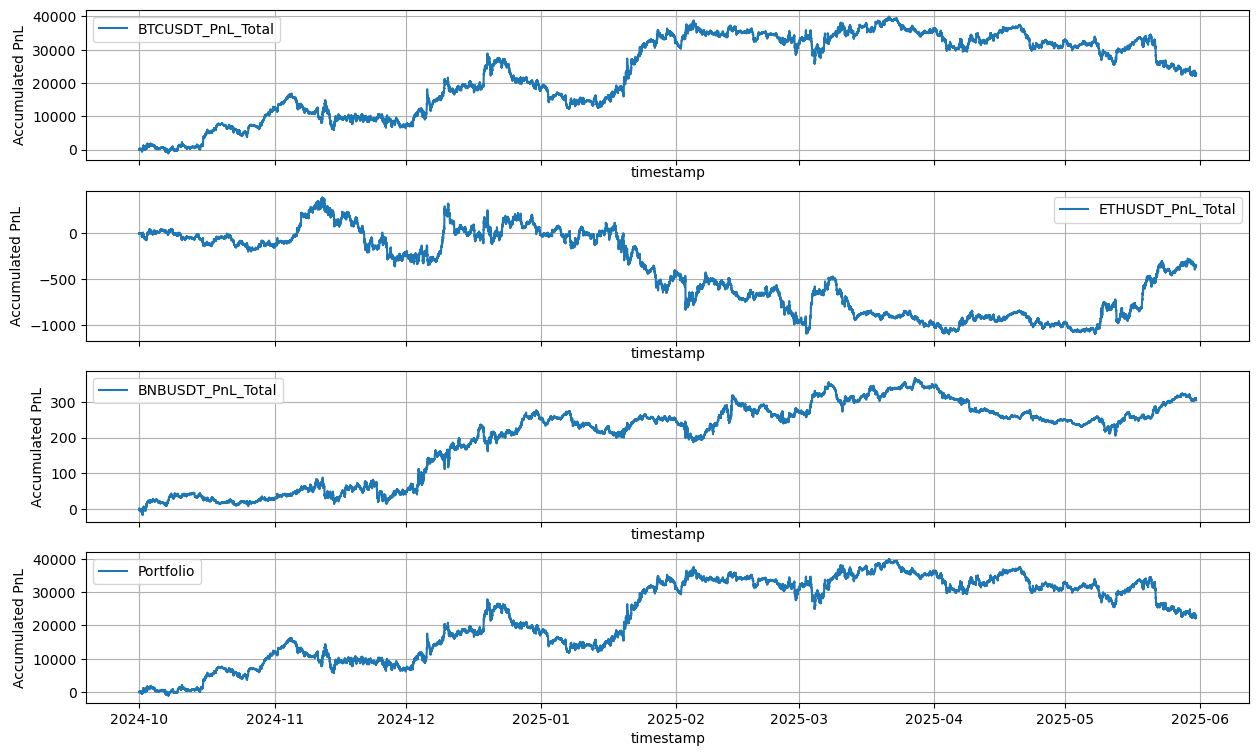

In [12]:
lr_backtest.plot_pnl(lr_pnl_df)

## Trend Strat



In [95]:
from Data.BinancePriceFetcher import *
from PnL_Metrics.PortfolioMetrics import *
from Utils.Hurst import *
from Utils.config import *


class TrendStrat:
    def __init__(self, df, tickers):
        self.df = df
        self.tickers = tickers


    def generate_signals(self, slow_ma_period, fast_ma_period, roc_period, execute_threshold, exit_threshold):
        # Calculate the rolling mean with a window size of lookback
        for t in self.tickers:
            self.df[t+'_slow_ma'] = self.df[t].rolling(window=slow_ma_period).mean()
            self.df[t+'_fast_ma'] = self.df[t].rolling(window=fast_ma_period).mean()
            self.df[t+'_momentum'] = self.df[t].pct_change(roc_period)

            # Generate signals
            self.df[t+'_signal'] = 0  # Default: no position
            self.df[t+'_exit_signal'] = 0  # Default: no exit

            # Long: Fast MA > Slow MA + Positive Momentum
            long_condition = (
                (self.df[t+'_fast_ma'] > self.df[t+'_slow_ma']) & 
                (self.df[t+'_momentum'] > execute_threshold)
            )
            
            # Short: Fast MA < Slow MA + Negative Momentum
            short_condition = (
                (self.df[t+'_fast_ma'] < self.df[t+'_slow_ma']) & 
                (self.df[t+'_momentum'] < -execute_threshold)
            )

            # Check for mean reversion property using Augmented Dickey-Fuller test
            is_mean_revert = []
            counter = 0
            for i in range(slow_ma_period, len(self.df)):
                if counter == slow_ma_period:
                    # Perform ADF test on lookback window
                    if adfuller(self.df[t][i-slow_ma_period:i].values)[1] < MeanReversionStrat_PARAMS.stationarity_cutoff:
                        is_mean_revert += [1] * slow_ma_period  # Series is mean-reverting
                    else:
                        is_mean_revert += [0] * slow_ma_period  # Series is not mean-reverting
                    counter = 0
                counter += 1

            
            self.df[t+'_is_mean_revert'] = [0] * (len(self.df) - len(is_mean_revert)) + is_mean_revert
            self.df[t+"_is_mean_revert"] = self.df[t+"_is_mean_revert"].fillna(0)
            

            exit_condition = (
                (abs(self.df[t+'_momentum']) < exit_threshold)
            )
            
            self.df.loc[long_condition, t+'_signal'] = 1
            self.df.loc[short_condition, t+'_signal'] = -1

             # Generate entry signals based on z-scores and mean reversion property
            self.df[t+'_signal'] = np.where(self.df[t+'_is_mean_revert'] == 1, 0, self.df[t+'_signal'])

            self.df.loc[exit_condition, t+'_exit_signal'] = 1

        return self.df
    
    
    def generate_single_signal(self, t, prices, slow_ma_period, fast_ma_period, roc_period, execute_threshold, exit_threshold):
        signals = self.generate_signals(slow_ma_period, fast_ma_period, roc_period, execute_threshold, exit_threshold)
        signal, exit_signal = signals.tail(1)[t+"_signal"].item(), signals.tail(1)[t+"_exit_signal"].item()
        bid, mid, ask = prices[0], prices[1], prices[2]

        signal_df = pd.DataFrame()
        signal_df['Tickers'] = [t]

        if signal == -1:
            price = bid
        elif signal == 1:
            price = ask
        else:
            price = mid
            
        # Store results
        signal_df['signals'] = [signal]
        signal_df['exit_signals'] = [exit_signal]
        signal_df['Price'] = price
        return signal_df

In [103]:
tr_model = TrendStrat(portfolio_prices.copy(), test_cons)
tr_signals = tr_model.generate_signals(slow_ma_period=12*24*10, fast_ma_period=12*24*3, roc_period=12*24*15, execute_threshold=0.2, exit_threshold=0.05)
tr_signals

,timestamp,BNBUSDT,BTCUSDT,ETHUSDT,BTCUSDT_slow_ma,BTCUSDT_fast_ma,BTCUSDT_momentum,BTCUSDT_signal,BTCUSDT_exit_signal,BTCUSDT_is_mean_revert,...,ETHUSDT_momentum,ETHUSDT_signal,ETHUSDT_exit_signal,ETHUSDT_is_mean_revert,BNBUSDT_slow_ma,BNBUSDT_fast_ma,BNBUSDT_momentum,BNBUSDT_signal,BNBUSDT_exit_signal,BNBUSDT_is_mean_revert
0,2024-07-01 00:00:00,582.00,62722.08,3437.02,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
1,2024-07-01 00:05:00,580.60,62648.49,3433.81,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
2,2024-07-01 00:10:00,580.40,62624.00,3435.74,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
3,2024-07-01 00:15:00,581.00,62682.02,3438.27,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
4,2024-07-01 00:20:00,581.30,62674.01,3438.29,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96188,2025-05-30 23:40:00,655.13,103802.36,2518.88,108439.334885,107012.109317,0.000174,0,1,0,...,-0.010609,0,1,0,674.603406,678.754965,0.006097,0,1,0
96189,2025-05-30 23:45:00,656.09,104067.40,2527.38,108438.357944,107006.321528,0.002812,0,1,0,...,-0.006826,0,1,0,674.605236,678.719630,0.007246,0,1,0
96190,2025-05-30 23:50:00,655.80,104010.45,2528.39,108437.433385,107000.596481,0.002800,0,1,0,...,-0.005499,0,1,0,674.607170,678.684225,0.006909,0,1,0
96191,2025-05-30 23:55:00,655.36,103985.48,2531.34,108436.438764,106994.864201,0.002137,0,1,0,...,-0.006807,0,1,0,674.609031,678.647708,0.005338,0,1,0


In [104]:
tr_backtest = Backtest(tr_signals.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
tr_pnl_df = tr_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
tr_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.0,0.000000e+00
1,2024-10-01 00:05:00,0.0,0.000000e+00
2,2024-10-01 00:10:00,0.0,0.000000e+00
3,2024-10-01 00:15:00,0.0,0.000000e+00
4,2024-10-01 00:20:00,0.0,0.000000e+00
...,...,...,...
69692,2025-05-30 23:40:00,0.0,-3.306467e+06
69693,2025-05-30 23:45:00,0.0,-3.306467e+06
69694,2025-05-30 23:50:00,0.0,-3.306467e+06
69695,2025-05-30 23:55:00,0.0,-3.306467e+06


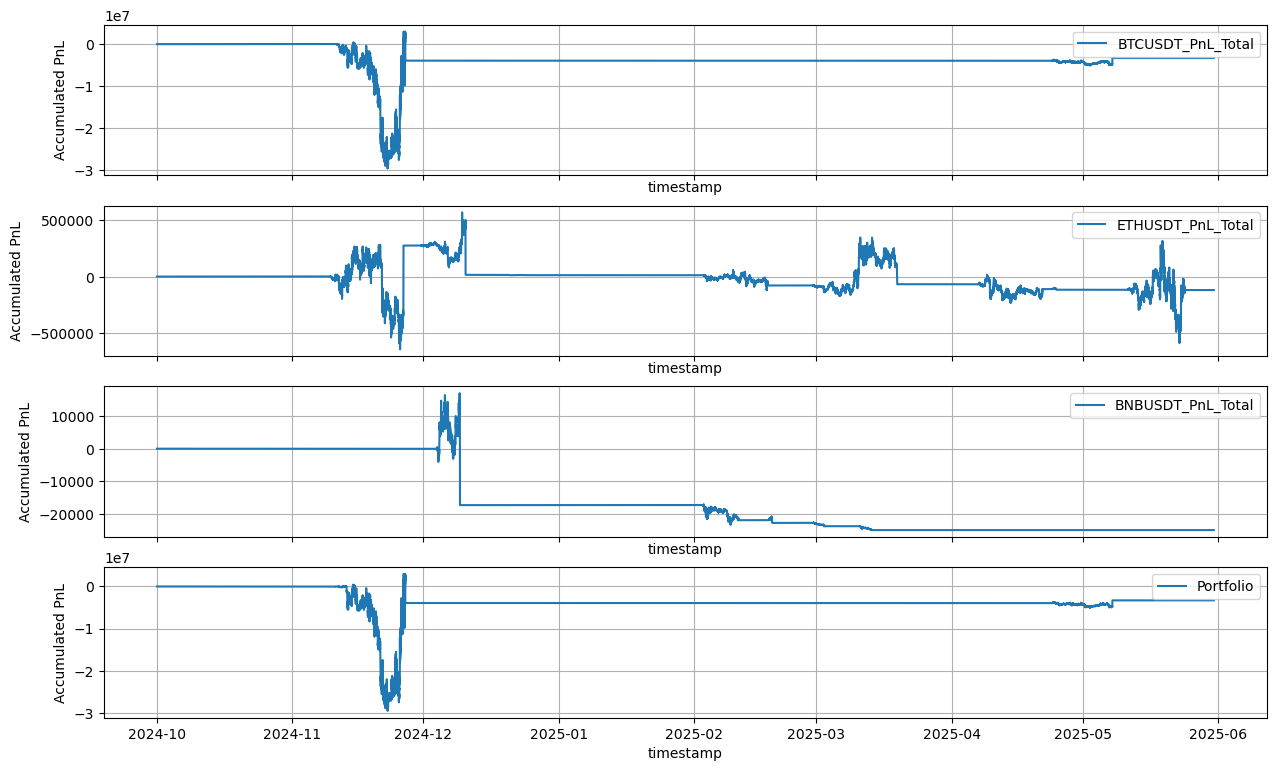

In [105]:
tr_backtest.plot_pnl(tr_pnl_df)

# Comparison

In [102]:
mr_returns = mr_backtest.get_returns(mr_pnl_df, notional = 10e6)
momentum_returns = simple_backtest.get_returns(simple_pnl_df, notional = 10e6)
lr_returns = lr_backtest.get_returns(lr_pnl_df, notional = 10e6)
tr_returns = tr_backtest.get_returns(tr_pnl_df, notional = 10e6)

returns = pd.DataFrame(list(zip(momentum_returns, mr_returns, lr_returns, tr_returns)), columns=['Simple', 'MeanRevert', 'Regression', 'Trend'])
port_metrics = PortfolioMetrics(returns.dropna(), periods_per_year=252*12*24)
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Simple               0.001179               0.003988      0.297434   
MeanRevert           0.505191               0.803908      0.856744   
Regression           0.004984               0.002805      1.773755   
Trend                     NaN              18.003167      0.355701   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio   Skewness  \
Simple                      38779     -0.002154      0.547377  18.559237   
MeanRevert                  38779     -0.394156      1.281703  88.418167   
Regression                  38779     -0.001610      3.096061   1.254656   
Trend                       38779     -1.000000           NaN  65.259629   

                Kurtosis  VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Simple       3718.089408 -0.000035  -0.000074     1.01328     1.012474  
MeanRevert  12678.287359 -0.000035  -0.004458     1.01328     1.079007  
Regression     69.580281 -0.000035  -0.000051    

In [14]:
wrc = WhiteRealityCheck(strategies=returns["MeanRevert"], benchmark=returns["Simple"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.141
consistent    0.141
upper         0.141
dtype: float64
Superior strategy indices:
[]


[]